# Homework 5

In this notebook, you will explore kernel ridge regression and kernel SVM. We first present kernel ridge regression on a housing dataset to showcase the ideas in Question 3 on the theoretical portion of the homework. Next, we start our exploration into kernel SVM with a two-dimensional example on the spiral data and then build a simple but powerful sentiment classifier on tweets to airlines, a topic we may have more sympathy for as inclement weather hits us here in Chicago...

## Preparation

In [1]:
# !gdown 1aZdzUafp91XYlv1xaVj7qpBXfVx8_Pvc

In [2]:
import os
import numpy as np
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn import svm
import matplotlib.pyplot as plt
import utils

## Kernel Ridge Regression

In the Question 3 of the theoretical homework, we studied kernel ridge regression. In this part, we will address the practical considerations for solving the kernel ridge regression problem.

We consider the [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), which consists of 8 numeric features, including house age, number of bedrooms, and location, and has target median house value. It contains over 20 thousand samples. We will use 3000 for now, but feel free to use more to see what happens! First, let us load it from `sklearn`'s set of datasets.

In [3]:
cal  = sklearn.datasets.fetch_california_housing()

In [4]:
from utils import TrainAndTestData

seed = 0
np.random.seed(seed)

m = 3000
perm = np.random.permutation(len(cal.target))
train_i = perm[:m]
test_i = perm[m:]
train_X = cal.data[train_i,:]
train_y = cal.target[train_i]
test_X = cal.data[test_i,:]
test_y = cal.target[test_i]

housing_data = TrainAndTestData(train_X, train_y, test_X, test_y)

Let use a Gaussian (RBF) kernel. Recall that the definition of this kernel is:

$$
    K_{RBF}(x_i, x_j) = \exp \left( -\beta \left(  \langle x_i, x_i \rangle + \langle x_j, x_j \rangle - 2\langle x_i, x_j \rangle  \right)    \right)
$$

In [5]:
def RBF_kernel(beta = 1):
    def RBF_kernel_beta(x1,x2):
        return np.exp(- beta*(np.sum(x1*x1, 1)[:,np.newaxis] + np.sum(x2*x2, 1)-2*x1@x2.T ))
    return RBF_kernel_beta

*A quick note on closure: the above kernel construction function employs a Python concept known as `closure` which provides us the following functionality. Every kernel function should have the same signature: given two data points as input, output a real number. However, the function may be dependent on some parameter that we cannot hard code. Thus, the outer function constructs a kernel function with the desired signature while fixing a value for the parameter. This becomes very useful when we may need to pass around a kernel function but always for the same parameter value*

To use this function, we first pick some value of `beta` and instantiate: `RBF_kernel(beta=myvalue)`. This is itself a function and can now take in matrices `x1, x2`. That is:

In [6]:
RBF_kernel(beta = 1)(housing_data.X_train[:10], housing_data.X_train[:10])

array([[1.00000000e+000, 0.00000000e+000, 1.24418120e-052,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [1.24418120e-052, 0.00000000e+000, 9.99999999e-001,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        5.13597624e-152],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.0

### [Task 1] Looking for a great $\beta$ value
Look at the values of the kernel with $\beta=1$. What pattern do you observe about the values? Generally, what is the largest value that a Gaussian kernel can achieve? What is the smallest value that a Gaussian kernel can achieve? How does the kernel with $\beta=1$ compare to the upper bound and the lower bound? You should notice this is not a good choice of $\beta$. How can you improve this? Find a good setting for $\beta$ by considering these questions.

In [7]:
#### TASK 1 CODE
beta=10**(-6)
betas = np.logspace(-7, -5, 10)
best_beta = 0
best_min = np.inf
for beta in betas:
    ker_data = RBF_kernel(beta = beta)(housing_data.X_train, housing_data.X_train)
    if np.min(ker_data[ker_data != 0]) < best_min:
        best_beta = beta
        best_min = np.min(ker_data[ker_data != 0])
ker_data = RBF_kernel(beta = best_beta)(housing_data.X_train, housing_data.X_train)
print(f"The max value attained in this kernel is {np.max(ker_data)} and the min value is {np.min(ker_data[ker_data != 0])}. The best beta is {best_beta}")
print(ker_data)
#### TASK 1 CODE

The max value attained in this kernel is 1.0000000000000535 and the min value is 1e-323. The best beta is 3.5938136638046257e-06
[[1.         0.79130504 0.99957057 ... 0.58989626 0.3135914  0.53029647]
 [0.79130504 1.         0.7871057  ... 0.94222565 0.70245401 0.90668556]
 [0.99957057 0.7871057  1.         ... 0.5858934  0.30955633 0.52558313]
 ...
 [0.58989626 0.94222565 0.5858934  ... 1.         0.87866743 0.9931472 ]
 [0.3135914  0.70245401 0.30955633 ... 0.87866743 1.         0.92342485]
 [0.53029647 0.90668556 0.52558313 ... 0.9931472  0.92342485 1.        ]]


In [8]:
beta = best_beta

Armed with a good kernel to represent our features well, we move on to the learning algorithm.

### [Task 2] Implementing Kernel Ridge Regression
Now, let us implement the kernel ridge regression solution `train_kernel_ridge`. In 2(b), you formulated the solution to the kernel ridge regression as computing the least squares solution to some expression. `predict_kernel_ridge` will compute the prediction given the kernel, the validation points $x$, the predictor $\alpha$, and the training points. Finish the functions below using proper numeric python syntax.

In [9]:
def train_kernel_ridge(kernel, lmbd, x, y):
    from numpy.linalg import lstsq
    K = kernel(x,x)
    #### TASK 2 CODE
    m = x.shape[0]
    A = (K +  lmbd * np.eye(m))
    least_squares_soln = np.linalg.lstsq(A, y)[0]
    #### TASK 2 CODE
    return least_squares_soln

In [10]:
def predict_kernel_ridge(kernel, x, alpha, train_x):
    #### TASK 2 CODE
    return kernel(x, train_x) @ alpha
    #### TASK 2 CODE

In [11]:
kernel = RBF_kernel(beta = beta)
lmbd = 0.1
alpha = train_kernel_ridge(kernel, lmbd, housing_data.X_train, housing_data.y_train)
train_preds = predict_kernel_ridge(kernel, housing_data.X_train, alpha, housing_data.X_train)

Given this, load and process the data into the Gram matrix, compute the KRR solution for this data for some fixed regularization parameter $\lambda$, and predict the answers on a validation set.

**Check yourself**: How long does the `train_kernel_ridge` function take to run? Are you inverting a matrix?

Great. You now are able to compute the KRR solution for data. Let's compute some baselines to know what we're trying to beat. Implement the following two (extremely simple) predictors. We will compute the mean squared error of them later.
* **null predictor**: output 0 for every data point
* **mean predictor**: output the mean of the training `y` for every data point

In [12]:
def mean_squared_error(pred, y):
    return np.mean((pred-y)**2)

In [13]:
#### TASK 2 CODE
## BASELINES
def null_predictor(x):
    return np.zeros(x.shape[0])

def mean_predictor(train_y, x):
    return np.mean(train_y) * np.ones(len(x))

#### TASK 2 CODE

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

For the code block below, use cross-validation or validation to choose $\lambda$. Make sure you beat the baselines. What values of $\beta, \lambda$ give good performance? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The best values of lambda and beta were found to be lambda=0.001 and beta = 2.9836472402833405e-06. The MSE is 0.5793619624415502
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

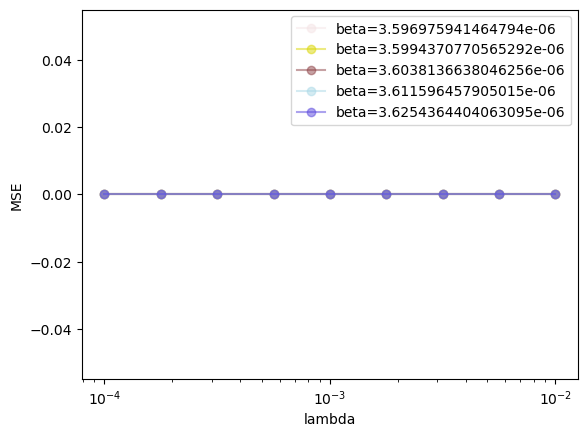

In [14]:
#### TASK 2 CODE
import sklearn.model_selection
import concurrent.futures
from worker import train_val_split

#init vars
lmbds = np.logspace(-4, -2, 9)
betas = best_beta + np.logspace(-8.5, -7.5, 5) # beta was found to be e-6
folds = 5
mses = np.zeros((len(betas), len(lmbds), folds))
kf = sklearn.model_selection.KFold(n_splits=folds)
rng = np.random.default_rng()

# parallelizing is broken in jupyter and windows, so it's necessary to have the worker function train_val_split in a separate file,
# so this actually trains in a reasonable amount of time
# all that's included in worker.py is this function

# def train_val_split(data, lmbd, train_index, test_index, kernel, train, predict, loss):
#     train_X, test_X = data.X_train[train_index], data.X_train[test_index]
#     train_y, test_y = data.y_train[train_index], data.y_train[test_index]
#     alpha = train(kernel, lmbd, train_X, train_y)
#     preds = predict(kernel, test_X, alpha, train_X)
#     return loss(preds, test_y)

#parallelize training and testing
if __name__ != '__main__':
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(train_val_split, housing_data, lmbd, train_index, test_index, RBF_kernel, beta, train_kernel_ridge, predict_kernel_ridge, mean_squared_error) :
                (beta_id, lmbd_id, fold) 
                for beta_id, beta in enumerate(betas)
                for lmbd_id, lmbd in enumerate(lmbds) 
                for fold, (train_index, test_index) in enumerate(kf.split(housing_data.X_train))
                }
        for future in concurrent.futures.as_completed(futures):
            kernel_id, lmbd_id, fold = futures[future]
            try:
                mses[kernel_id, lmbd_id, fold] = future.result()
            except Exception as exc:
                print(f'generated an exception: {exc}')
            else:
                print(f'finished fold {fold} with lambda {lmbds[lmbd_id]} and beta {betas[kernel_id]}')

mses = mses.mean(axis=-1)
colors = dict(zip(betas, rng.choice(range(256), size=(len(betas), 3), replace=False)/255))
for beta_id, beta in enumerate(betas):
    plt.plot(lmbds, mses[beta_id], marker='o', linestyle='-', color=colors[beta], alpha=0.5, label=f'beta={beta}')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.legend()
plt.show()
#### TASK 2 CODE

In [15]:
best_lmbd = lmbds[mses.argmin()]
best_mse = mses.min()
null_mse = mean_squared_error(null_predictor(housing_data.X_train), housing_data.y_train)
mean_mse = mean_squared_error(mean_predictor(housing_data.y_train, housing_data.X_train), housing_data.y_train)
print(f"Kernel Ridge Regression MSE: {best_mse}, with lambda={best_lmbd}, and beta={best_beta}")
print(f"Null predictor MSE: {null_mse}")
print(f"Mean predictor MSE: {mean_mse}")

Kernel Ridge Regression MSE: 0.0, with lambda=0.0001, and beta=3.5938136638046257e-06
Null predictor MSE: 5.575252963671465
Mean predictor MSE: 1.3331326837230717


## 2D kernel SVM

In this part, we see how SVM works on 2d data. We will walk through solving this problem using different kernels. You need to explore different kernels and parameter settings to understand the effect of the hyperparameters. We will use the [implementation of SVM in `scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which does the following. You can find more details [here](https://scikit-learn.org/1.6/modules/svm.html#svc).

Given training vectors $x_i \in \mathbb{R}^p$, $i=1,\dots,n$, in two classes, and a vector $y \in \{1, -1\}^n$, our goal is to find $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by:

$$
\text{sign}(w^T \phi(x) + b)
$$

is correct for most samples.

SVC solves the following primal problem:

$$
\min_{w,b,\zeta} \quad \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i
$$

subject to:

$$
y_i (w^T \phi(x_i) + b) \geq 1 - \zeta_i,
$$

$$
\zeta_i \geq 0, \quad i = 1, \dots, n
$$

Intuitively, we're trying to maximize the margin (by minimizing $ \|w\|^2 = w^T w $), while incurring a penalty when a sample is misclassified or within the margin boundary. Ideally, the value $ y_i (w^T \phi(x_i) + b) $ would be $ \geq 1 $ for all samples, which indicates a perfect prediction. But problems are usually not always perfectly separable with a hyperplane, so we allow some samples to be at a distance $ \zeta_i $ from their correct margin boundary.

The penalty term $ C $ controls the strength of this penalty.

`svm.SVC` supports built-in **RBF, polynomial, and linear kernels**, which we have covered in class. To help you understand how they work, we implement a **polynomial kernel** below. You can also find the code for the **RBF kernel** at the beginning of the notebook.

To verify that everything works correctly, try using both **our defined kernel** and `SVC`'s built-in kernels and compare the results.

We have prepared three toy demo datasets, each containing 10 positive samples and 10 negative samples. You are encouraged to run SVM on each demo set and explore different **kernels**, **hyperparameters**, and **regularization settings** to understand how these factors influence the learned classifier.
- Spend some time analyzing the impact of these choices, as they will be critical in later sections.
- In the next part, you will work with **higher-dimensional data**, where visualization is not as straightforward. This makes it even more important to understand how hyperparameters affect your model now.

In [16]:
from utils import get_demo

def poly_kernel(degree = 2, beta = 1 , a = 1):
    def poly_kernel_inst(x1,x2):
        return (beta * x1@x2.T + a)**degree
    return poly_kernel_inst


def train_and_plot_svm(data, C=None, **args):
    svm_clf = svm.SVC(**args,C=C)
    svm_clf = svm_clf.fit(data.X_train, data.y_train)
    utils.plot_decision_boundary_with_svm(svm_clf, data.X_train, data.y_train, data.X_test, data.y_test, C=C)
    # utils.plot_decision_boundary_with_svm(svm_clf, data.X_train, data.y_train, None, None, C=C)
    # you can also avoid passing C by checking for margin violations based on the response being less then 1
    if data.y_test is not None:
        data.print_errors(svm_clf)
    return svm_clf

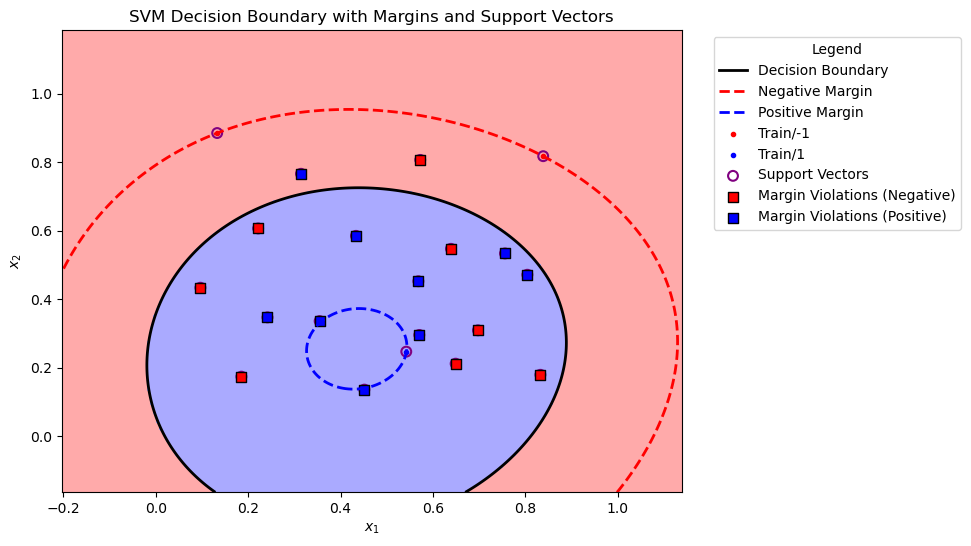

In [17]:
 # Select demo by choosing 1, 2, or 3
demo = get_demo(3)  # Change the number (1, 2, or 3) to load a different demo

# Set hyperparameters for the SVM model
C = 5
gamma = 1

# Train and plot SVM using a custom RBF kernel (default option)
svm_clf = train_and_plot_svm(demo, C=C, kernel=RBF_kernel(beta=gamma))

# Alternative: Use the built-in RBF kernel from sklearn's SVC (if needed)
# Uncomment the line below to use sklearn's built-in RBF kernel instead of the custom one
# svm_clf = train_and_plot_svm(demo, C=C, kernel='rbf', gamma=gamma)

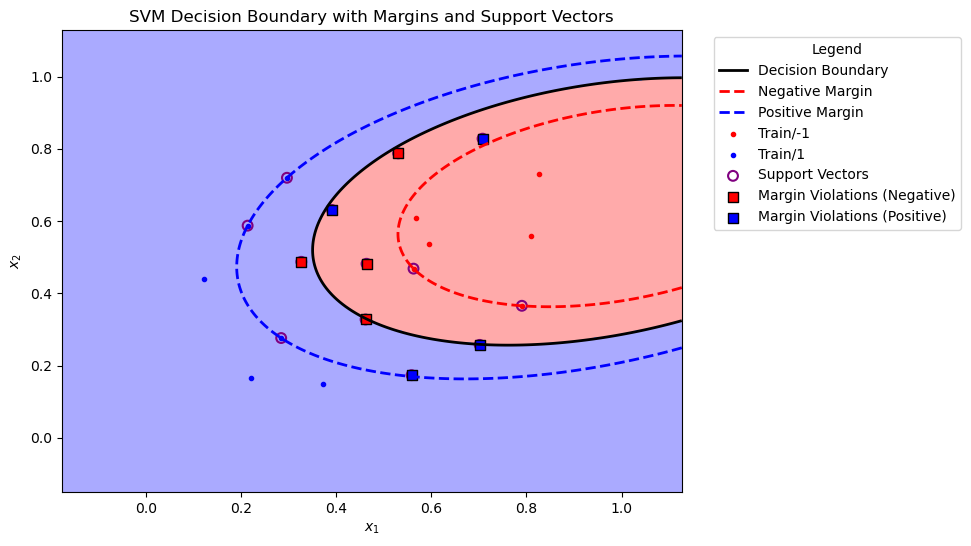

In [18]:
# Select demo by choosing 1, 2, or 3
demo = get_demo(1)  # Change the number to load a different demo

# Set SVM hyperparameters
C = 5
degree = 3
beta = 2
a = 1

# Train and plot SVM using the custom polynomial kernel (default)
svm_clf = train_and_plot_svm(demo, C=C, kernel=poly_kernel(degree=degree, beta=beta, a=a))

# Alternative: Use the built-in polynomial kernel from sklearn's SVC
# Uncomment the line below to use sklearn's polynomial kernel instead of the custom one
# svm_clf = train_and_plot_svm(demo, C=C, kernel='poly', degree=degree, gamma=beta, coef0=a)

Now we will move from toy demo data to spiral dataset that you are very familiar with. 

In [19]:
np.random.seed(0)

LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

train_test_ratio = 0.8
Xsp_train, ysp_train, Xsp_test, ysp_test = utils.create_split(Xsp, ysp, train_test_ratio)

spirals = TrainAndTestData(Xsp_train, ysp_train, Xsp_test, ysp_test)

Explore how the **RBF kernel** performs on the spiral dataset by varying gamma(beta) and observing its effect on the decision boundary.  
- Try **different values of gamma**, including extreme ones, to understand how it influences model behavior.  
- You can find more details on **gamma in the RBF kernel** [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#rbf-kernel).

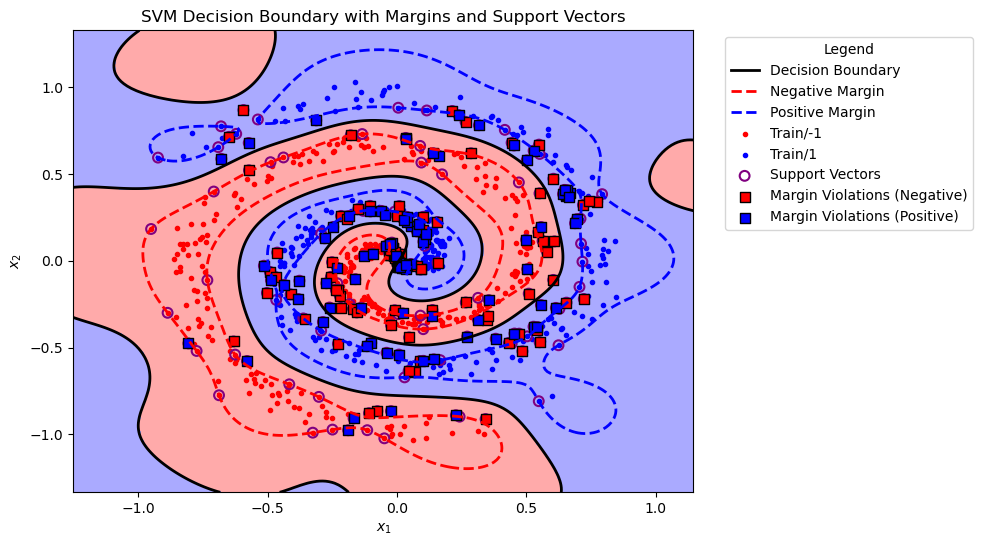

Train error: 9.00%
Test error: 6.00%


In [20]:
# Set hyperparameters for the SVM model

C = 5       
gamma = 10

# Train and plot SVM using a custom RBF kernel (default option)
svm_clf = train_and_plot_svm(spirals, C=C, kernel=RBF_kernel(beta=gamma))

# Alternative: Use the built-in RBF kernel from sklearn's SVC (if needed)
# Uncomment the line below to use sklearn's built-in RBF kernel instead of the custom one
# svm_clf = train_and_plot_svm(spirals, C=C, kernel='rbf', gamma=gamma)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 2]</h4>
How does the choice of gamma affect the decision boundary? What happens when gamma is set to very high or very low values?
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: When gamma is very small the decision boundary is far more linear, in the sense of the domain. When gamma is very high, the decision boundary is far more squiggly. 

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

See how polynoimal kernel works on the spiral data. You should try different numbers for degree, scaling factor gamma(beta) and bias term a to see how the decision boundard looks like. The hyperparameters are defined [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#polynomial-kernel)

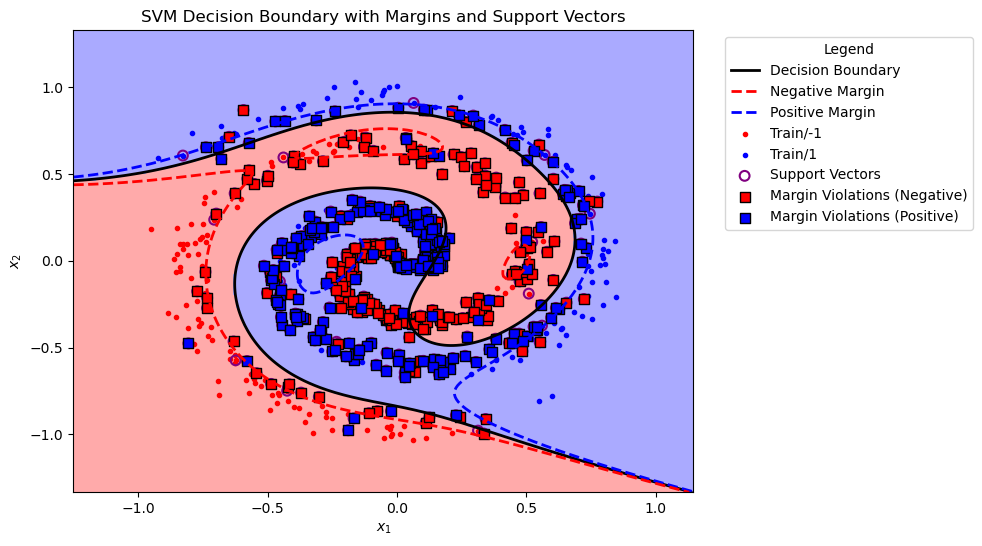

Train error: 24.88%
Test error: 26.50%


In [21]:
# Set SVM hyperparameters
C = 5
degree = 5
gamma = 1
a = 10

# Train and plot SVM using the custom polynomial kernel (default)
svm_clf = train_and_plot_svm(spirals, C=C, kernel=poly_kernel(degree=degree, beta=gamma, a=a))

# Alternative: Use the built-in polynomial kernel from sklearn's SVC
# Uncomment the line below to use sklearn's polynomial kernel instead of the custom one
# svm_clf = train_and_plot_svm(spirals, C=C, kernel='poly', degree=degree, gamma=gamma, coef0=a)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 3]</h4>
How does the choice of degree, scaling factor gamma(beta) and bias term a affect the decision boundary?
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: When the degree is high, the training takes longer and the generalization error increases due to overfitting, but since the training error massively decreases, the generalization error also decreases. For small gamma, the decision boundary gets closer to linear. For large gamma, the decision boundary becomes not linear. As a increases the eccentricity of the decision boundary increases.

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 3] Applying SVM classifiers to the 2D spiral data
For the classifier you trained, you need to finish code below to compute training loss, training error, margin violations and the number of support vectors.

In [ ]:
#### TASK 3 CODE
# training loss: hinge loss of svm_clf
train_loss = np.mean(np.maximum(0, 1 - svm_clf.decision_function(Xsp_test) * ysp_test))
print(f"Hinge loss: {train_loss}")

# training error
train_err = np.mean(np.sign(svm_clf.predict(Xsp_test)) != ysp_test)
print(f"Train error: {train_err}")

# margin violations
margin_violations = 
print(f"Margin violations: {margin_violations}")

# number of support vectors
num_support_vectors = 
print(f"Number of support vectors: {num_support_vectors}")
#### TASK 3 CODE

Hinge loss: 0.6820381932413048
Train error: 0.265


NameError: name 'margin_violations' is not defined

<span style="color: red">
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

## Sentiment Analysis Using Kernel SVM

Next, we will develop a sentiment classifier using kernel SVM. We will work with a real-world dataset of [tweets to airlines](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). Datasets that have been scraped from the internet (such as this one) are prone to many issues, whether we use them directly or with some filtering. See if you can think of a few potential issues, and feel free to discuss with TAs at office hours. Despite these issues, the dataset provides value in giving us short statements with strong sentiment that we will build a classifier over.

**Data pre-processing** The raw data, which you can access and study at the above link, contains 15 attributes, including `tweet_id` , `airline_sentiment`, `negative_reason`, `airline`, `text.` Of these, we are most interested in `airline_sentiment` and `text`. To that end, we have extracted these for you in the files `cleaned_tweets_train.tsv`. A `tsv` file is a file where the different attributes are separated by tabs. The dataset identifies three different sentiments: `positive`, `neutral`, and `negative`. After extracting just the tweets and the sentiments, we shuffled all the tweets and saved the first 3/4 of them to the training file and the remaining 1/4 of them to the test file.

**Data loading** The `load_data` function we provide in `utils.py` allows filtering neutral (i.e., removing them from the data) by setting `filter_neutrals` flag to `True` or including them but counting them as "not positive" examples by setting `filter_neutrals` flag to `False`.

In [ ]:
!mkdir $PWD/data/
import gdown
gdown.download(f"https://drive.google.com/uc?id=1acMRrRzHQdni-WVtMZOTwOEQGmcGWvcM", "./data/cleaned_tweets_train.tsv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id=1S_o4sBJs2uWJfEPLsykzsgBM8gYx_gzw", "./data/cleaned_tweets_test.tsv", quiet=False)

### Kernel Functions

Recall that a kernel can be defined as $K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle\, \in \mathbb{R}\,.$ However, the $x_i$ does not have to be real-valued, or numeric at all. Indeed, in this case, they are strings of length $k$ (tweets, in particular) in $\mathcal{D}^k$, where $\mathcal{D}$ is the dictionary of words. Then, we can decompose the kernel as:


$$
K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle = \langle \tilde{\phi}(v(x_i)), \tilde{\phi}(v(x_j))\rangle\
$$


where $\phi = \tilde{\phi} \circ v\,,$ $\tilde{\phi} \, : \mathbb{R}^{d_1} \mapsto \mathbb{R}^{d_2}$ and $v \, : \mathcal{D}^k \mapsto \mathbb{R}^{d_1}\,.$

This decomposition allows us to separate the transformation into two parts. Now, we can choose both independently. Here are some suggestions for each:

* For $v(x_i)\,:$
    * **Bag-of-words**: for each word $w$ in the corpus, the corresponding component of the bag-of-words representation of $x_i$ is defined as the number of occurences of $w$ in $x_i$.
    * **Bi-gram**: for each pair of words that occur contiguously in the corpus, the corresponding component of the bi-gram representation of $x_i$ is the number of times that the bi-gram (two-word pattern) appears in $x_i$.
    * **Subsequence counts**: for each subsequence (of fixed size) in the corpus, the corresponding component of this representation of $x_i$ is the number of times that the subsequence has appeared in the document $x_i.$ (A subsequence allows for skipping characters, whereas a substring is all continguous characters.)
    * ...others?



* For $\tilde{\phi}\,:$
    * Linear
    * Polynomial
    * Radial basis function
    * Weighted cosine similarity
    * ...others?

**Check your understanding**:
* what is the dimension of a bag-of-words representation of a sentence? what about bigram?

In [30]:
def BoW_inner(s1,s2):
    "returns inner product between bag-of-word feature vectors of the two input strings"
    from collections import Counter
    d1 = Counter(s1.split())
    return sum(d1[w] for w in s2.split())

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 4]</h4>

No coding in this one: Consider the BoW kernel constructed in `BoW_inner`. Suppose there are $D$ words in the corpus, and each sentence (document) has at most $k$ words.
* What is the time and space complexity of naively constructing the bag-of-words vector for each sentence and computing their inner product?
* What is the time and space complexity of the implementation in the code?
* What accounts for the difference? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer:

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 4] Implementing your own feature mapping function for text data

Think about your own understanding of sentences. What features do you use to understand them? **Hand design a feature mapping from sentence to numeric values that might help a kernel learn to classify sentiment.** To do this, you may wish to load the training data and inspect what positive and negative samples look like.

In [ ]:
X_train, y_train = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"),type="train")

In [ ]:
print("---- positive samples ----")
for i in range(100):
    if y_train[i] == 1:
        print(X_train[i])
print("--------------------------")
print("---- negative samples ----")
for i in range(100):
    if y_train[i] == -1:
        print(X_train[i])
print("--------------------------")

In [34]:
def my_feature_map(x1): ### You should rename this to be more descriptive about the feature mapping that you are using
    #### TASK 4 CODE
    # This is an open question, so we will not provide a fixed solution, but you
    # are encouraged to share your ideas in the course discussion over Canvas!
    #### TASK 4 CODE
    pass

In [35]:
def my_inner_product(x1, x2):
    '''
    this function computes the inner product phi(x1)*phi(x2) for phi,
        the feature transform defined in the previous cell, i.e., my_feature_map
    implementing this as np.dot(my_feature_map(x1), my_feature_map(x2)) is not
        super-useful, as the runtime will be at least linear in the dimension of
        the feature map. Instead, implement this without ever using my_feature_map.
    '''
    #### TASK 4 CODE
    # This is an open question, so we will not provide a fixed solution, but you
    # are encouraged to share your ideas in the course discussion over Canvas!
    #### TASK 4 CODE
    pass

Next, we compute the Gram matrix from any kernel we have implemented (e.g., the one you just implemented or the bag-of-words example given in function `BoW_inner`. This is useful in computing $\tilde{\phi}$ for $\tilde{\phi}$ that can be vectorized.

In [36]:
def gram_matrix(K):
    def gram_matrix_K(xs_1, xs_2):
        return np.array([[K(x1, x2) for x2 in xs_2] for x1 in xs_1])
    return gram_matrix_K

In [37]:
def rbf_kernel_gram(inner, beta=1):
    """Gaussian RBF kernel.

    Returns a functoin gram(xs_1,xs_2) that calculate the (cross) gram matrix G[i,j]=K(xs_1[i,xs_2[j]])
    where K is the Gaussian RBF on the features phi, specified through the inner product in phi space."""
    def rbf_kernel_sigma_inner(xs_1,xs_2):
        return np.exp(-beta*(np.array([inner(x1, x1) for x1 in xs_1])[:, np.newaxis]
                             + np.array([inner(x2, x2) for x2 in xs_2])
                             - 2*gram_matrix(inner)(xs_1, xs_2)))
    return rbf_kernel_sigma_inner

In [38]:
def poly_kernel_gram(inner, deg, alpha=1.0):
    def poly_kernel_deg_alpha(xs_1, xs_2):
        return (alpha + gram_matrix(inner)(xs_1, xs_2))**deg
    return poly_kernel_deg_alpha

Let us see how to generate the RBF kernel matrix using `BoW_inner` and `my_inner_product` as $\langle v(x_i), v(x_j)\rangle$ for some value of the parameter $\beta\,.$ Note that `rbf_kernel_gram(inner, beta)` returns a function, and we pass it the datasets as arguments.

In [ ]:
rbf_kernel_gram(BoW_inner,0.2)(X_train[:10],X_train[5:12])

In [ ]:
rbf_kernel_gram(my_inner_product,0.2)(X_train[:10],X_train[5:12])

### [Task 5] Optimizing your SVM classifier

Now that we know how to extract and kernelize our data, let us train SVM on it. As an example, here is how you might use `sklearn`'s SVM implementation:

In [ ]:
# fit svm with a small subset of data
svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, 2))
svm_clf= svm_clf.fit(X_train[:100], y_train[:100])
preds = svm_clf.predict(X_train[100:120])
print(preds)

Here, poly_kernel_gram computes the polynomial kernel matrix on the fly. This means that every time `SVC` is called, it must re-compute all pairwise inner products between feature vectors. While this approach is fine for small datasets, it becomes computationally expensive for large-scale problems. 
### Using a Precomputed Kernel

To improve efficiency, we can **precompute the kernel matrix** before passing it to `SVC`. This allows us to reuse the computed values instead of recalculating them multiple times.

#### How Precomputed Kernels Work in SVM

- Instead of providing raw feature vectors to `SVC`, we **compute and store the Gram matrix** (a matrix of pairwise similarities).
- This Gram matrix replaces the need for direct feature input.
- The model expects a **square matrix** for training (size $ n \times n$), where each entry represents the kernel function applied to a pair of training samples.
- During testing, we compute a **test vs. train kernel matrix** (size $ m \times n $) to compare new samples against the training set.

Below is the example and you will see it gives the same prediction as above. 

In [ ]:
# Compute the Gram matrix for training
K_train = poly_kernel_gram(BoW_inner, 2) (X_train[:100], X_train[:100])

# Train SVM using the precomputed kernel matrix
svm_clf = svm.SVC(kernel='precomputed')
svm_clf.fit(K_train, y_train[:100])

# Compute the Gram matrix for testing 
K_test = poly_kernel_gram(BoW_inner, 2) (X_train[100:120], X_train[:100]) # Notice: X_test vs X_train

# Predict using the precomputed test kernel
preds = svm_clf.predict(K_test)
print(preds)

In [ ]:
# fit svm with entire training data
# it can take several minutes to run
svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, 2))
svm_clf= svm_clf.fit(X_train, y_train)
preds = svm_clf.predict(X_train)

Note that $C = 1/\lambda\,,$ where $\lambda$ is the regularization parameter we discussed in class. Use a validation set to evaluate the performance of the classifiers you train.

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 5]</h4>


<!-- <h4 style="font-weight: bold">---------------------</h4> -->

We give you a set of questions below to explore and some direction regarding how to explore them. As your "answer" for this section, submit a write-up in the notebook with 2-3 plots about the answers to these questions. Also submit your code as applicable. You can finish them with a small subset of training data but you are encouraged to try the entire training dataset with the precomputed kernel trick. 

* For different kernels, train SVM with different $\lambda$ spanning a good range. Use cross validation to determine a good value of $\lambda$. What are the resulted (1) 0-1, Hinge training loss? (2) Margin loss? (3) Test error? (4) Support Vectors? If using a precomputed kernel, cross-validation requires special handling. Since the Gram matrix depends on the training set, you need to extract the corresponding submatrices for each training split in cross-validation. The training submatrix should only include training samples, and the validation submatrix should compare validation samples against the training set.

* Identify examples where the classifier fails for different kernels. Speculate on what the various kernels might be more suited to.

* You implemented your own kernel: how did that do? Did the performance match what you were expecting? If not, what factors might have influenced that?

* Consider the various attributes of a machine learning algorithm we may be interested in practically: generalization, runtime, memory usage, ease of implementation, understandability. How does kernel SVM for the kernels you tried perform on each of these attributes?


<span style="color: blue">
Answer: 
</span>




After evaluating different classifiers you developed based on various design choices, evaluate the performance of the one you've chosen to "ship". 

In [ ]:
def my_final_predictor(x_data_to_predict_on): # you might change the input if you use precomputed kernels
    #### TASK 5 CODE
    my_predictions =      # an array of +1/-1 the same length as x_data_to_predict
    #### TASK 5 CODE
    return my_predictions

You are now ready to ship your predictor!!  Hurray!!  
Let's use it, and see how well it does.

In [ ]:
X_test = utils.load_data(os.path.join(os.getcwd(), "data/cleaned_tweets_test.tsv"),type="test")

In [42]:
test_predictions = my_final_predictor(X_test)

In [ ]:
print(f"My predictions: {test_predictions}") ### this should be a list of +1/-1 ###
print(f"It if of length {len(test_predictions)}.") ### this should of size X_test = 2192 ###

Yay, It did not crash!! Now let us convert the list into a csv file. You can export the tsv file and submit it on [Kaggle](https://www.kaggle.com/t/ed3bead259169073ec68e3e9fbf6b247), to see yourself on the leaderboard!!!


In [ ]:
with open("y_predicted.csv", "w") as f:
    f.write("ID,label\n")  # Write header
    for i, label in enumerate(test_predictions, start=1):
        f.write(f"{i},{label}\n")  # Write ID and label